<a href="https://colab.research.google.com/github/zakirangwala/esrb-wizard/blob/main/notebooks/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Do Players Prefer Games with Mature Content?**

# Data Cleanse & Preprocessing

In [113]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
import ast

In [114]:
from google.colab import drive
drive.mount('/content/drive')

#load data
clf_df = pd.read_csv("/content/drive/MyDrive/CP322/classification.csv") # save to github: notebooks/classification.ipynb

print(clf_df.shape)
clf_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(113132, 96)


,Peak CCU,Price,Discount,DLC count,Windows,Mac,Linux,Metacritic score,User score,Achievements,...,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled,played_before,esrb_available
0,0,19.99,0,0,1,0,0,0,0,30,...,0,0,0,0,0,0,0,0,0,0
1,0,0.99,0,0,1,1,0,0,0,12,...,0,0,0,0,0,0,0,0,0,0
2,0,4.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5.99,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.00,0,0,1,1,0,0,0,17,...,0,0,0,0,0,0,0,0,0,0


In [115]:
#define target and features
clf_df = clf_df.rename(columns={'played_before': 'played_past_2weeks'})
TARGET_COL = "played_past_2weeks"

#columns that leak "Average playtime two weeks"

leak_cols = [
    "Average playtime two weeks",
]

cols_to_drop = [TARGET_COL] + [c for c in leak_cols if c in clf_df.columns]

#drop target, IDs, and leakage columns
X = clf_df.drop(columns=cols_to_drop, errors="ignore")
y = clf_df[TARGET_COL].astype(int)

#keep only numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X = X[numeric_cols]

print("Final feature columns:", list(numeric_cols))
print("X shape:", X.shape)
print("y value counts:")
print(y.value_counts())

clf_df.head()

Final feature columns: ['Peak CCU', 'Price', 'Discount', 'DLC count', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'User score', 'Achievements', 'Recommendations', 'release_year', 'midpoint_estimated_owners', 'esrb_age', 'voice_acting', '%_positive_reviews', '360 Video', 'Accounting', 'Action', 'Adventure', 'Animation & Modeling', 'Audio Production', 'Casual', 'Design & Illustration', 'Documentary', 'Early Access', 'Education', 'Episodic', 'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Movie', 'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Short', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Tutorial', 'Utilities', 'Video Production', 'Violent', 'Web Publishing', 'Captions available', 'Co-op', 'Commentary available', 'Cross-Platform Multiplayer', 'Family Sharing', 'Full controller support', 'HDR available', 'In-App Purchases', 'Includes Source SDK', 'Includes level editor', 'LAN Co-op', 'LAN PvP', 'MMO', 'Mods', 'Mods (require HL2)', 'Mult

,Peak CCU,Price,Discount,DLC count,Windows,Mac,Linux,Metacritic score,User score,Achievements,...,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled,played_past_2weeks,esrb_available
0,0,19.99,0,0,1,0,0,0,0,30,...,0,0,0,0,0,0,0,0,0,0
1,0,0.99,0,0,1,1,0,0,0,12,...,0,0,0,0,0,0,0,0,0,0
2,0,4.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5.99,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.00,0,0,1,1,0,0,0,17,...,0,0,0,0,0,0,0,0,0,0


In [116]:
from sklearn.model_selection import train_test_split

#train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,
    stratify=y,
    random_state=42,
)

X_test.columns = [c.replace(' ', '_') for c in X_test.columns]
X_temp.columns = [c.replace(' ', '_') for c in X_temp.columns]

#split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1/0.9,       #0.11 of 0.90 = 0.10. final 80/10/10 split
    stratify=y_temp,
    random_state=42,
)

print("Train size:", X_train.shape[0])
print("Val size:",   X_val.shape[0])
print("Test size:",  X_test.shape[0])
print("")
print("Train class balance:")
print(y_train.value_counts(normalize=True))

Train size: 90504
Val size: 11314
Test size: 11314

Train class balance:
played_past_2weeks
0    0.975791
1    0.024209
Name: proportion, dtype: float64


In [117]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    average_precision_score,
    precision_recall_curve,
)

# Dataframe to compare performance metrics on classifier models
classifier_performance_data = {'Metric': ['Average Precision', 'Accuracy', 'AUC_ROC', 'Precision', 'Recall', 'F1 Score']}

clf_performance = pd.DataFrame(classifier_performance_data)
clf_performance = clf_performance.set_index('Metric')
clf_performance.head(7)

""
Metric
Average Precision
Accuracy
AUC_ROC
Precision
Recall
F1 Score


# Random Forest Classifier

In [118]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def randomForestObjective(trial):
    # paramaters to hypertune
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 15, 45)
    min_samples_split = trial.suggest_int("min_samples_split", 5, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    #max_features = trial.suggest_int("max_features", 1, X_temp.shape[1]) #50
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])


    # random forest classifier
    clf_rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        max_features=max_features,
        class_weight=class_weight,
        bootstrap=bootstrap,
        criterion=criterion,
        n_jobs=-1
    )

    # precision is the best metric for such an imbalanced dataset
    prec_score = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring="average_precision").mean()

    return prec_score

# Utilize Optuna to obtain the best parameters
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(randomForestObjective, n_trials=5)
best_params_rf = study_rf.best_params

# print best parameters
print("Best hyperparameters:", best_params_rf)
print("Best average precision:", study_rf.best_value)

[I 2025-11-22 05:26:59,899] A new study created in memory with name: no-name-d4d7d896-c387-437c-8476-945f5ac41a42
[I 2025-11-22 05:27:21,437] Trial 0 finished with value: 0.778438806122923 and parameters: {'n_estimators': 131, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced', 'bootstrap': True, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.778438806122923.
[I 2025-11-22 05:27:46,222] Trial 1 finished with value: 0.7678728065674932 and parameters: {'n_estimators': 114, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.778438806122923.
[I 2025-11-22 05:35:03,897] Trial 2 finished with value: 0.6657696617350952 and parameters: {'n_estimators': 352, 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'bootst

Best hyperparameters: {'n_estimators': 131, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced', 'bootstrap': True, 'criterion': 'log_loss'}
Best average precision: 0.778438806122923


balanced sub_sample as a class weight consistently makes the score low. sqrt is better than log2. More features leads to lower scores

Trial 13 finished with value: 0.765587526567404 and parameters: {'n_estimators': 122, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 40}. Best is trial 13 with value: 0.765587526567404.

{'n_estimators': 311, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 40, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7885331937288078.

In [119]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# refit model based on best parameters
clf_rf = RandomForestClassifier(
    **best_params_rf,
    random_state=42,
    n_jobs=-1
)

# check model fit based on cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_train_proba = cross_val_predict(
    clf_rf,
    X_train,
    y_train,
    cv=skf,
    method='predict_proba'
)[:, 1]

y_train_class = (y_train_proba >= 0.5).astype(int)

print("\nTRAIN METRICS:")
print("Average Precision:", average_precision_score(y_train, y_train_proba))
print("Accuracy:", accuracy_score(y_train, y_train_class))
print("ROC AUC:", roc_auc_score(y_train, y_train_proba))
print("F1:", f1_score(y_train, y_train_class))
print("Precision:", precision_score(y_train, y_train_class))
print("Recall:", recall_score(y_train, y_train_class))


# threshold tuning based on validation set
clf_rf.fit(X_train, y_train)
y_val_proba = clf_rf.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

best_thresh = thresholds[f1_scores[:-1].argmax()]
print("\nBest threshold for F1 (val set):", best_thresh)

# retrain final model based on training and validation sets
clf_rf_final = RandomForestClassifier(
    **best_params_rf,
    random_state=42,
    n_jobs=-1
)

clf_rf_final.fit(X_temp, y_temp)

# performance of model against the test dataset
y_test_proba = clf_rf_final.predict_proba(X_test)[:, 1]
y_test_class = (y_test_proba >= best_thresh).astype(int)

print("\nTEST METRICS:")
print("Average Precision:", average_precision_score(y_test, y_test_proba))
print("Accuracy:", accuracy_score(y_test, y_test_class))
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("F1 score:", f1_score(y_test, y_test_class))
print("Precision:", precision_score(y_test, y_test_class))
print("Recall:", recall_score(y_test, y_test_class))

# add metrics to table for comparison later
clf_performance['Random Forest'] = [average_precision_score(y_test, y_test_proba),
                                    accuracy_score(y_test, y_test_class),
                                    roc_auc_score(y_test, y_test_proba),
                                    precision_score(y_test, y_test_class),
                                    recall_score(y_test, y_test_class),
                                    f1_score(y_test, y_test_class),
                                    ]


TRAIN METRICS:
Average Precision: 0.776100637744737
Accuracy: 0.9812052505966588
ROC AUC: 0.9858415140914373
F1: 0.668227033352838
Precision: 0.5834468664850136
Recall: 0.7818347786398905

Best threshold for F1 (val set): 0.6298686397084055

TEST METRICS:
Average Precision: 0.7628382750170671
Accuracy: 0.9842672794767544
ROC AUC: 0.9755808341267322
F1 score: 0.6810035842293907
Precision: 0.6690140845070423
Recall: 0.6934306569343066


# XGBoost Classifier

In [120]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# https://www.google.com/search?q=Zero-Inflated+Bernoulli+%28ZIBer%29+Model+python&sca_esv=16a5b3c49c9a2e73&sxsrf=AE3TifMOdqtXCBqe2iRojqJlBYye0wsDBw%3A1763759245463&ei=jdQgadSGHNKe0PEPm_qyqAw&ved=0ahUKEwiUga6ak4SRAxVSDzQIHRu9DMUQ4dUDCBE&uact=5&oq=Zero-Inflated+Bernoulli+%28ZIBer%29+Model+python&gs_lp=Egxnd3Mtd2l6LXNlcnAiLFplcm8tSW5mbGF0ZWQgQmVybm91bGxpIChaSUJlcikgTW9kZWwgcHl0aG9uMgUQABjvBTIFEAAY7wVIlhRQ2wVY7BJwBHgAkAEAmAHXAaABtgiqAQUxLjUuMbgBA8gBAPgBAZgCC6AC2gjCAggQABiwAxjvBcICCxAAGIAEGLADGKIEwgIFECEYnwXCAggQABiABBiiBMICBBAhGBXCAgcQIRigARgKmAMAiAYBkAYEkgcFNS41LjGgB_EMsgcFMS41LjG4B84IwgcGMC4xMC4xyAcV&sclient=gws-wiz-serp

In [121]:
from xgboost import XGBClassifier

#compute scale_pos_weight for imbalance (pos / neg)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1.0
print("scale_pos_weight:", scale_pos_weight)

def xgboostObjective(trial):
    # paramaters to hypertune
    eval_metric = trial.suggest_categorical("eval_metric", ["logloss", "aucpr"])
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_int("gamma", 0, 5)
    max_delta_step = trial.suggest_int("max_delta_step", 0, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.1, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    # xgboost classifier
    clf = XGBClassifier(
        objective="binary:logistic",
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        max_delta_step=max_delta_step,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
    )

    # precision is the best metric for such an imbalanced dataset
    prec_score = cross_val_score(clf, X_train, y_train, cv=5, scoring="average_precision").mean()

    return prec_score

# Utilize Optuna to obtain the best parameters
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(xgboostObjective, n_trials=5)
best_params_xgb = study_xgb.best_params

# print best parameters
print("Best hyperparameters:", best_params_xgb)
print("Best average precision:", study_xgb.best_value)

[I 2025-11-22 05:36:09,691] A new study created in memory with name: no-name-be7dc435-b47a-4502-b177-41834ab670a7


scale_pos_weight: 40.30716567777271


[I 2025-11-22 05:36:39,616] Trial 0 finished with value: 0.7907196652009723 and parameters: {'eval_metric': 'logloss', 'n_estimators': 374, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 1, 'max_delta_step': 2, 'learning_rate': 0.028662893992699348, 'subsample': 0.39434057802935407, 'colsample_bytree': 0.5647473868524009, 'reg_alpha': 0.48713774619575767, 'reg_lambda': 0.7082238824775777}. Best is trial 0 with value: 0.7907196652009723.
[I 2025-11-22 05:36:59,800] Trial 1 finished with value: 0.759449120773238 and parameters: {'eval_metric': 'aucpr', 'n_estimators': 303, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 4, 'max_delta_step': 7, 'learning_rate': 0.28002643660946525, 'subsample': 0.4764116766672738, 'colsample_bytree': 0.832707942565877, 'reg_alpha': 0.923299533806383, 'reg_lambda': 6.980896091712951}. Best is trial 0 with value: 0.7907196652009723.
[I 2025-11-22 05:37:21,327] Trial 2 finished with value: 0.7741175922417131 and parameters: {'eval_metric': 'logloss', 'n_es

Best hyperparameters: {'eval_metric': 'logloss', 'n_estimators': 339, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 3, 'max_delta_step': 5, 'learning_rate': 0.06173733094333623, 'subsample': 0.970467163025804, 'colsample_bytree': 0.6858295916779147, 'reg_alpha': 0.5614740497849433, 'reg_lambda': 0.6078612505428227}
Best average precision: 0.7911501643407005


In [122]:
# refit model based on best parameters
clf_xgb = XGBClassifier(
    objective="binary:logistic",
    **best_params_xgb,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

# check model fit based on cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_train_proba = cross_val_predict(
    clf_xgb,
    X_train,
    y_train,
    cv=skf,
    method='predict_proba'
)[:, 1]

y_train_class = (y_train_proba >= 0.5).astype(int)

print("\nTRAIN METRICS:")
print("Average Precision:", average_precision_score(y_train, y_train_proba))
print("Accuracy:", accuracy_score(y_train, y_train_class))
print("ROC AUC:", roc_auc_score(y_train, y_train_proba))
print("F1:", f1_score(y_train, y_train_class))
print("Precision:", precision_score(y_train, y_train_class))
print("Recall:", recall_score(y_train, y_train_class))


# threshold tuning based on validation set
clf_xgb.fit(X_train, y_train)
y_val_proba = clf_xgb.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

best_thresh = thresholds[f1_scores[:-1].argmax()]
print("\nBest threshold for F1 (val set):", best_thresh)

# retrain final model based on training and validation sets
clf_xgb_final = XGBClassifier(
    objective="binary:logistic",
    **best_params_xgb,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

clf_xgb_final.fit(X_temp, y_temp)

# performance of model against the test dataset
y_test_proba = clf_xgb_final.predict_proba(X_test)[:, 1]
y_test_class = (y_test_proba >= best_thresh).astype(int)

print("\nTEST METRICS:")
print("Average Precision:", average_precision_score(y_test, y_test_proba))
print("Accuracy:", accuracy_score(y_test, y_test_class))
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("F1 score:", f1_score(y_test, y_test_class))
print("Precision:", precision_score(y_test, y_test_class))
print("Recall:", recall_score(y_test, y_test_class))

# add metrics to table for comparison later
clf_performance['XGBoost'] = [average_precision_score(y_test, y_test_proba),
                                    accuracy_score(y_test, y_test_class),
                                    roc_auc_score(y_test, y_test_proba),
                                    precision_score(y_test, y_test_class),
                                    recall_score(y_test, y_test_class),
                                    f1_score(y_test, y_test_class),
                                    ]


TRAIN METRICS:
Average Precision: 0.7873800693042208
Accuracy: 0.9580792009192964
ROC AUC: 0.9873141996505386
F1: 0.5128402670775553
Precision: 0.35679828479542613
Recall: 0.9114559561843907

Best threshold for F1 (val set): 0.93522424

TEST METRICS:
Average Precision: 0.7634848630149247
Accuracy: 0.9833834187732013
ROC AUC: 0.9825187771077964
F1 score: 0.6736111111111112
Precision: 0.6423841059602649
Recall: 0.708029197080292


# LightGBM

In [123]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

def lightGBMObjective(trial):
    # paramaters to hypertune
    n_estimators = trial.suggest_int("n_estimators", 200, 1000)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    num_leaves = trial.suggest_int("num_leaves", 16, 64)
    max_depth = trial.suggest_int("max_depth", 5, 15)
    min_child_samples = trial.suggest_int("min_child_samples", 20, 200)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.6, 0.8)
    feature_fraction = trial.suggest_float("feature_fraction", 0.6, 0.9)

    # xgboost classifier
    clf = LGBMClassifier(
        boosting_type="gbdt",
        is_unbalance=True,
        n_estimators=n_estimators,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        max_depth=max_depth,
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        min_child_samples=min_child_samples,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    # precision is the best metric for such an imbalanced dataset
    prec_score = cross_val_score(clf, X_train, y_train, cv=5, scoring="average_precision").mean()

    return prec_score

# Utilize Optuna to obtain the best parameters
study_light = optuna.create_study(direction="maximize")
study_light.optimize(lightGBMObjective, n_trials=5)
best_params_light = study_light.best_params

# print best parameters
print("Best hyperparameters:", best_params_light)
print("Best average precision:", study_light.best_value)

[I 2025-11-22 05:38:17,236] A new study created in memory with name: no-name-827101f1-ba76-4426-b21c-0413e290d8e9
[I 2025-11-22 05:38:42,757] Trial 0 finished with value: 0.7926651395572258 and parameters: {'n_estimators': 522, 'learning_rate': 0.0352116966676634, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 95, 'reg_alpha': 0.40690479765708376, 'reg_lambda': 5.764050238109252, 'bagging_fraction': 0.7272975146349254, 'feature_fraction': 0.6799858031636938}. Best is trial 0 with value: 0.7926651395572258.
[I 2025-11-22 05:39:08,074] Trial 1 finished with value: 0.7794463018603865 and parameters: {'n_estimators': 694, 'learning_rate': 0.09889570637787692, 'num_leaves': 48, 'max_depth': 7, 'min_child_samples': 108, 'reg_alpha': 0.09929377997950262, 'reg_lambda': 8.992343952681496, 'bagging_fraction': 0.6047555884831927, 'feature_fraction': 0.772898205508031}. Best is trial 0 with value: 0.7926651395572258.
[I 2025-11-22 05:39:38,265] Trial 2 finished with value: 0.7816874899249

Best hyperparameters: {'n_estimators': 522, 'learning_rate': 0.0352116966676634, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 95, 'reg_alpha': 0.40690479765708376, 'reg_lambda': 5.764050238109252, 'bagging_fraction': 0.7272975146349254, 'feature_fraction': 0.6799858031636938}
Best average precision: 0.7926651395572258


In [129]:
# refit model based on best parameters
clf_light = LGBMClassifier(
    **best_params_light,
    random_state=42,
    n_jobs=-1
)

# check model fit based on cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_train_proba = cross_val_predict(
    clf_light,
    X_train,
    y_train,
    cv=skf,
    method='predict_proba'
)[:, 1]

y_train_class = (y_train_proba >= 0.5).astype(int)

print("\nTRAIN METRICS:")
print("Average Precision:", average_precision_score(y_train, y_train_proba))
print("Accuracy:", accuracy_score(y_train, y_train_class))
print("ROC AUC:", roc_auc_score(y_train, y_train_proba))
print("F1:", f1_score(y_train, y_train_class))
print("Precision:", precision_score(y_train, y_train_class))
print("Recall:", recall_score(y_train, y_train_class))


# threshold tuning based on validation set
clf_light.fit(X_train, y_train)
y_val_proba = clf_light.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

best_thresh = thresholds[f1_scores[:-1].argmax()]
print("\nBest threshold for F1 (val set):", best_thresh)

# retrain final model based on training and validation sets
clf_light_final = LGBMClassifier(
    **best_params_light,
    random_state=42,
    n_jobs=-1
)

clf_light_final.fit(X_temp, y_temp)

# performance of model against the test dataset
y_test_proba = clf_light_final.predict_proba(X_test)[:, 1]
y_test_class = (y_test_proba >= best_thresh).astype(int)

print("\nTEST METRICS:")
print("Average Precision:", average_precision_score(y_test, y_test_proba))
print("Accuracy:", accuracy_score(y_test, y_test_class))
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("F1 score:", f1_score(y_test, y_test_class))
print("Precision:", precision_score(y_test, y_test_class))
print("Recall:", recall_score(y_test, y_test_class))

# add metrics to table for comparison later
clf_performance['LightGBM'] = [average_precision_score(y_test, y_test_proba),
                                    accuracy_score(y_test, y_test_class),
                                    roc_auc_score(y_test, y_test_proba),
                                    precision_score(y_test, y_test_class),
                                    recall_score(y_test, y_test_class),
                                    f1_score(y_test, y_test_class),
                                    ]


TRAIN METRICS:


ValueError: Found input variables with inconsistent numbers of samples: [90504, 11314]

# Performance Metric Comparison

In [125]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# https://www.google.com/search?q=zero-inflated+bernoulli+(ziber)+model+python&oq=zero+inflated+&gs_lcrp=EgZjaHJvbWUqBggBECMYJzIGCAAQRRg5MgYIARAjGCcyBggCECMYJzINCAMQABiRAhiABBiKBTINCAQQABiRAhiABBiKBTINCAUQABiRAhiABBiKBTIHCAYQABiABDIHCAcQABiABDIHCAgQABiABDIHCAkQABiABNIBCDU0MjVqMGo0qAIAsAIA&sourceid=chrome&ie=UTF-8

In [126]:
clf_performance.head(7)

,Random Forest,XGBoost,LightGBM
Metric,,,
Average Precision,0.762838,0.763485,0.772786
Accuracy,0.984267,0.983383,0.984179
AUC_ROC,0.975581,0.982519,0.983364
Precision,0.669014,0.642384,0.658863
Recall,0.693431,0.708029,0.718978
F1 Score,0.681004,0.673611,0.687609


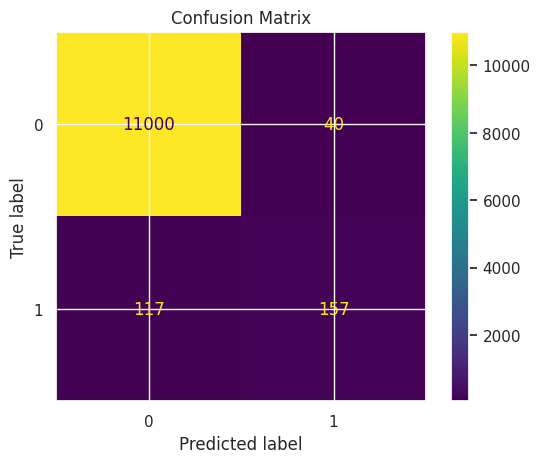

In [127]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

best_clf = clf_light_final # CHANGE THIS ACCORDING TO RESULTS

y_pred_test = best_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()